# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [2]:
!nvidia-smi

Fri Apr  8 14:20:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   36C    P0    53W / 300W |   7163MiB / 32505MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
dataset='CHEMBL205'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
#df = pd.read_csv(path/f'{dataset}.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978')]

# Generate activations

In [7]:
DATA = path/'mol_images'

# Create train validation split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    df = pd.read_csv(path/f'{dataset}/{dataset}_cl.csv')
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df

In [10]:
df = get_df(dataset)

# Create dataloader

In [11]:
from fastai.vision.all import *

In [12]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [13]:
def get_dls(dataset, df, random_state=42, test_size=0.2, bs=64):
    IMAGES = DATA/dataset
    x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=random_state, stratify=df['Activity'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['CID'] + '.png'
    images = df['CID'] + ".png"
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=batch_tfms,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True)
    return dls

In [14]:
dls = get_dls(dataset, df, random_state=42)

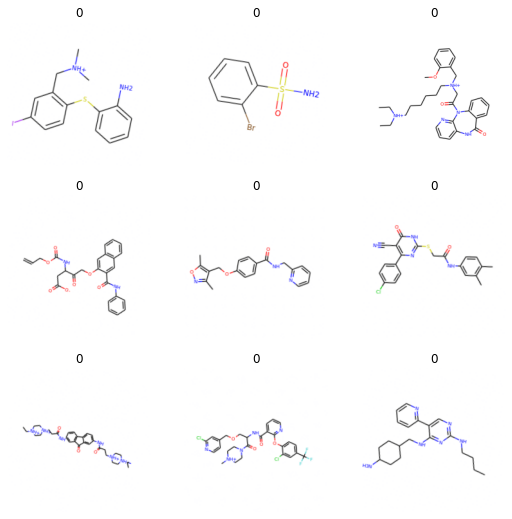

In [15]:
dls.show_batch()

In [16]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [17]:
loss_func = get_loss_func(df)

# Train CNN model

In [18]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [19]:
def train_model(dls, arch=resnet18, loss_func=loss_func, epochs=10, wd=None, lr=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [20]:
# Train model on resnet18
learn = train_model(dls, epochs=30, lr=3e-3, wd=0.002)

Training model on dataset: CHEMBL205
Architechture: <function resnet18 at 0x7fb3ebdeae60>
Trained epochs: epochs=30
Weight decay: wd=0.002


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mmiv-ml/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.499128,0.298689,0.885483,0.559486,0.429984,0.800613,0.937031,0.532462,00:17


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.285012,0.232053,0.930064,0.707118,0.570621,0.929448,0.970508,0.695720,00:20
1,0.229874,0.164494,0.950125,0.769032,0.663697,0.914110,0.978781,0.753817,00:20
2,0.197384,0.204844,0.941488,0.740099,0.620332,0.917178,0.978261,0.725728,00:20
3,0.167103,0.140962,0.952076,0.770667,0.681604,0.886503,0.974748,0.752439,00:21
4,0.180734,0.168254,0.947060,0.763092,0.642857,0.938650,0.979260,0.751152,00:21
5,0.172567,0.141729,0.948732,0.767089,0.653017,0.929448,0.981385,0.753822,00:22
6,0.196148,0.128835,0.960156,0.800000,0.735219,0.877301,0.981560,0.781811,00:20
7,0.157870,0.115784,0.961828,0.814111,0.729927,0.920245,0.979800,0.799769,00:21
8,0.155938,0.130292,0.962664,0.818919,0.731884,0.929448,0.983204,0.805521,00:20
9,0.144753,0.138384,0.957091,0.804569,0.686147,0.972393,0.986868,0.796268,00:20


In [21]:
interp = ClassificationInterpretation.from_learner(learn)

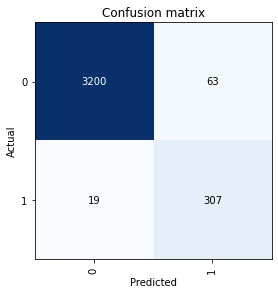

In [22]:
interp.plot_confusion_matrix()

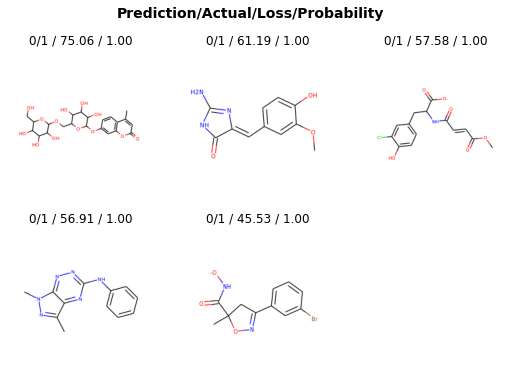

In [23]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [24]:
IMAGES=path/f'mol_images/{dataset}'

In [31]:
learn.export(fname= f'models/activation_model.pkl')

In [32]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [33]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [34]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [35]:
df_nodupl=df

In [36]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

In [37]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [38]:
test_dls.items.head()

,CID,SMILES,Image,Activity,is_valid
2373,CHEMBL553555,O(C(C)C)c1ccccc1N1CC[NH+](CC1)Cc1nc(ccc1)CN1CCCCC1=O,CHEMBL553555.png,0,False
15364,CHEMBL1771216,S(=O)(=O)(C1(CC[NH+](CC1)CCOC)C(=O)N[O-])c1ccc(OCCCn2nc(nn2)-c2ccc(OC(F)(F)F)cc2)cc1,CHEMBL1771216.png,0,False
9721,CHEMBL1490423,O=C(Nc1cc([NH+]([O-])[O-])ccc1)c1ccc(cc1)C(C)(C)C,CHEMBL1490423.png,0,False
11324,CHEMBL595318,Clc1cc(NCCNC(=O)CCc2ccc(NS(=O)(=O)C)cc2)ccc1Cl,CHEMBL595318.png,0,False
9707,CHEMBL1088868,O1C(C[NH+](CCC([NH3+])C(=O)[O-])CCCN[C-]([NH3+])N)C(O)C(O)C1n1c2ncnc(N)c2nc1,CHEMBL1088868.png,0,False


In [39]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

In [40]:
test_df = test_dls.items.reset_index()

In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17941 non-null  int64 
 1   CID       17941 non-null  object
 2   SMILES    17941 non-null  object
 3   Image     17941 non-null  object
 4   Activity  17941 non-null  int64 
 5   is_valid  17941 non-null  object
dtypes: int64(2), object(4)
memory usage: 841.1+ KB


In [42]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Image     17941 non-null  object
 3   Activity  17941 non-null  int64 
 4   is_valid  17941 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.9+ KB


# Check

In [43]:
test_df.loc[test_df.CID == 'CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
5618,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [44]:
df_nodupl.loc[df_nodupl.CID == 'CHEMBL1089637']

,CID,SMILES,Image,Activity,is_valid
1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [45]:
test_dls.dataset

(#17941) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0))...]

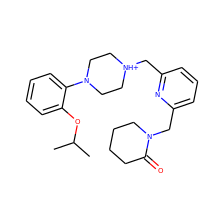

In [46]:
test_dls.dataset[0][0]

In [47]:
test_df.loc[test_df.CID=='CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
5618,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [48]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [49]:
t_img, t_cat = get_data('CHEMBL1089637')

5618


In [50]:
len(test_dls.dataset)

17941

In [51]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

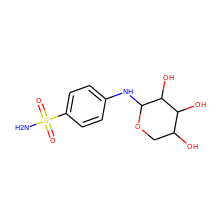

In [52]:
t_img

In [53]:
df_nodupl['activations'] = None

In [54]:
def get_activations(CID, ret=False):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    print(idx)
    data = get_data(CID)
    img = data[0]
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]
    #df_nodupl.iloc[idx]['acts'] = list(acts)
    if not ret: 
        df_nodupl.at[idx, 'activations'] = list(acts)
    if ret: 
        return list(acts)

In [55]:
df_nodupl.CID.values[0]

'CHEMBL188002'

In [56]:
%%capture
for CID in df_nodupl.CID.values:
    get_activations(CID)

In [57]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,"[7.2002573, -9.18788, -8.3707075, -5.1156816, -16.728865, 4.383287, -9.854235, -11.6442585, 0.032814622, -6.683228, -12.489563, -3.1788425, -12.805599, -7.422662, -4.003844, -11.100757, -5.515949, -10.427739, -3.2878852, 1.7174025, 8.489077, -2.6361032, 0.63262045, 2.6325605, -7.661781, -9.35758, 0.7428998, -7.025601, 9.002351, -1.1605983, -2.7241492, 3.9858403, -10.240498, -4.6844606, -3.6733751, 11.78944, -4.66323, 0.8747508, -1.3974947, -3.4010007, -0.9748622, 5.8147345, -2.3180737, -13.773152, -9.834102, -2.2666416, -0.5322355, -10.78408, -6.312273, -7.7710075, 2.2057447, -10.35723, -9..."
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,"[-20.814634, -33.455093, -9.184986, -12.696633, -5.397111, 9.122849, -10.3816805, -17.460226, -6.395609, -2.0381804, -12.100116, -11.211214, -32.415203, -11.845132, -13.0425825, -9.179966, 3.6461368, -36.7921, -1.7669353, -16.237123, 20.580782, -10.838084, -0.734619, -27.165966, -2.19211, -14.199879, 3.145342, -9.63647, 12.369705, -21.747862, -11.431252, -7.6356416, -38.88713, -4.032521, -0.9565755, -3.1400762, -13.215182, -29.090805, -19.654415, -7.6557107, -26.306534, 16.090988, -14.170832, -25.86961, -16.510788, 12.259166, -24.527573, -27.877396, 0.28394008, -5.8633847, -22.033466, -8.2..."
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,"[-15.898125, -29.553547, -11.019605, -14.064631, -9.696257, 4.3678284, -15.621982, -19.211071, -4.3554096, -3.6331258, -12.265899, -9.837395, -29.768488, -15.156034, -9.006515, -13.847315, -0.5128622, -32.212906, -5.47514, -5.26863, 18.589237, -4.8561916, 0.481047, -16.141073, 2.0374057, -16.849396, 5.298249, -10.736481, 11.724825, -15.918377, -8.320704, -7.3608937, -37.212013, -6.6422596, -3.3513744, -0.6447106, -9.50204, -17.165606, -15.042527, -11.245689, -19.354052, 11.591503, -10.236979, -26.42775, -14.463164, 12.128505, -16.96777, -28.023605, -2.3562965, -8.003163, -13.182794, -7.374..."
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,"[-2.9687157, 0.64806706, -8.115684, -13.79864, 15.445815, 6.3148685, -3.5577252, -5.209405, -17.043297, -5.3988886, -13.74336, 4.1252427, -23.671919, -6.595575, -3.8570511, -2.1454024, 12.858107, -21.879148, -0.6298994, 3.7393384, 17.065804, -3.9910703, -23.523329, 1.34617, 3.7808723, 10.20591, -3.3571248, 8.102532, -16.367315, -1.6201422, -10.268391, -17.5245, -9.316834, -12.718666, -13.684425, -14.785621, -2.6219125, -1.0029517, 2.7647986, -0.62413716, 0.18074572, -8.1284685, -7.823744, -23.017776, -10.081445, 7.6232047, -4.418297, -22.212254, -10.873132, -14.278454, 0.70427734, -5.47149..."
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,"[-2.890897, -4.0651073, -7.94969, -13.867883, 15.609436, 6.907188, -0.2908794, -2.8667927, -14.651231, -7.9885917, -15.4868, -5.5682216, -22.657183, -6.5776095, -5.6692405, -2.321436, 13.495143, -19.665941, -1.2765435, -2.6130543, 18.62429, -7.4502463, -22.107395, -3.9329147, 3.601678, 8.245949, -3.3865156, 3.9764647, -13.674087, -2.804618, -8.029018, -20.202423, -11.733248, -14.713705, -9.028595, -12.469163, -6.2684402, -1.790161, -1.8433564, -0.40380216, -2.3384109, -14.722947, -7.362947, -26.93412, -11.759323, 10.965577, -7.640673, -22.347244, -8.097746, -15.256705, -2.873013, -2.230761..."


In [58]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CID          17941 non-null  object
 1   SMILES       17941 non-null  object
 2   Image        17941 non-null  object
 3   Activity     17941 non-null  int64 
 4   is_valid     17941 non-null  object
 5   activations  17941 non-null  object
dtypes: int64(1), object(5)
memory usage: 841.1+ KB


In [96]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [97]:
df_acts.drop('activations', axis=1, inplace=True)

In [98]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,7.200257,-9.187880,-8.370708,-5.115682,-16.728865,...,6.013904,-8.492347,-10.444207,-2.047073,-5.056983,2.265453,-6.920007,-4.305928,-8.030125,-4.809241
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,-20.814634,-33.455093,-9.184986,-12.696633,-5.397111,...,7.148327,-39.211136,-9.618040,-17.673176,-19.583109,6.854912,-8.774099,-0.059781,-7.925891,-9.708332
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,-15.898125,-29.553547,-11.019605,-14.064631,-9.696257,...,9.032317,-34.823502,-15.041724,-7.882508,-16.724415,6.908682,-11.689029,-6.013932,-7.165393,-8.932006
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,-2.968716,0.648067,-8.115684,-13.798640,15.445815,...,-18.723991,-15.862899,9.153879,-5.479111,-7.501410,-3.389281,-18.552248,-8.755526,6.710783,-9.599868
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,-2.890897,-4.065107,-7.949690,-13.867883,15.609436,...,-19.845070,-21.142094,4.649142,-9.205055,-6.960517,-0.245623,-17.479069,-4.328880,5.834792,-11.179177


In [99]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float32(512), int64(1), object(4)
memory usage: 35.7+ MB


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Add ECFP to dataframe

In [66]:
df_ecfp = pd.read_csv(path/f'{dataset}/{dataset}_cl_ecfp_512.csv')

In [67]:
df_ecfp.head()

,CID,SMILES,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_504,ECFP4_505,ECFP4_506,ECFP4_507,ECFP4_508,ECFP4_509,ECFP4_510,ECFP4_511,ECFP4_512,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 515 entries, CID to Activity
dtypes: int64(513), object(2)
memory usage: 70.5+ MB


In [69]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float32(512), int64(1), object(4)
memory usage: 35.7+ MB


In [70]:
df = df_ecfp.merge(df_acts, on='CID')

In [71]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,6.013904,-8.492347,-10.444207,-2.047073,-5.056983,2.265453,-6.920007,-4.305928,-8.030125,-4.809241
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,7.148327,-39.211136,-9.618040,-17.673176,-19.583109,6.854912,-8.774099,-0.059781,-7.925891,-9.708332
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,9.032317,-34.823502,-15.041724,-7.882508,-16.724415,6.908682,-11.689029,-6.013932,-7.165393,-8.932006
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-18.723991,-15.862899,9.153879,-5.479111,-7.501410,-3.389281,-18.552248,-8.755526,6.710783,-9.599868
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-19.845070,-21.142094,4.649142,-9.205055,-6.960517,-0.245623,-17.479069,-4.328880,5.834792,-11.179177


In [72]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [73]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,6.013904,-8.492347,-10.444207,-2.047073,-5.056983,2.265453,-6.920007,-4.305928,-8.030125,-4.809241
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,7.148327,-39.211136,-9.618040,-17.673176,-19.583109,6.854912,-8.774099,-0.059781,-7.925891,-9.708332
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,9.032317,-34.823502,-15.041724,-7.882508,-16.724415,6.908682,-11.689029,-6.013932,-7.165393,-8.932006
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-18.723991,-15.862899,9.153879,-5.479111,-7.501410,-3.389281,-18.552248,-8.755526,6.710783,-9.599868
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-19.845070,-21.142094,4.649142,-9.205055,-6.960517,-0.245623,-17.479069,-4.328880,5.834792,-11.179177


In [74]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [75]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [76]:
df.to_csv(path/f'{dataset}/{dataset}_ecfp_512_activations_512.csv', index=None)

# Create PCA dataframe

In [148]:
n_components = 32

In [149]:
all_activations = df_acts[[f'act_{i}' for i in range(0, 512)]]
all_activations.head()

,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,7.200257,-9.187880,-8.370708,-5.115682,-16.728865,4.383287,-9.854235,-11.644258,0.032815,-6.683228,...,6.013904,-8.492347,-10.444207,-2.047073,-5.056983,2.265453,-6.920007,-4.305928,-8.030125,-4.809241
1,-20.814634,-33.455093,-9.184986,-12.696633,-5.397111,9.122849,-10.381680,-17.460226,-6.395609,-2.038180,...,7.148327,-39.211136,-9.618040,-17.673176,-19.583109,6.854912,-8.774099,-0.059781,-7.925891,-9.708332
2,-15.898125,-29.553547,-11.019605,-14.064631,-9.696257,4.367828,-15.621982,-19.211071,-4.355410,-3.633126,...,9.032317,-34.823502,-15.041724,-7.882508,-16.724415,6.908682,-11.689029,-6.013932,-7.165393,-8.932006
3,-2.968716,0.648067,-8.115684,-13.798640,15.445815,6.314868,-3.557725,-5.209405,-17.043297,-5.398889,...,-18.723991,-15.862899,9.153879,-5.479111,-7.501410,-3.389281,-18.552248,-8.755526,6.710783,-9.599868
4,-2.890897,-4.065107,-7.949690,-13.867883,15.609436,6.907188,-0.290879,-2.866793,-14.651231,-7.988592,...,-19.845070,-21.142094,4.649142,-9.205055,-6.960517,-0.245623,-17.479069,-4.328880,5.834792,-11.179177


In [150]:
#all_activations = all_activations.astype('float16')

In [151]:
x = StandardScaler().fit_transform(all_activations)
x

array([[ 0.5979684 , -0.6063498 , -0.7933525 , ..., -0.22644895,
        -0.7325199 , -0.44416016],
       [-2.2931912 , -2.1112673 , -0.8866022 , ...,  0.02775278,
        -0.71996087, -0.8937983 ],
       [-1.7858033 , -1.8693151 , -1.0966995 , ..., -0.3287011 ,
        -0.62832874, -0.82254714],
       ...,
       [ 0.17867465,  0.5785997 ,  0.10818772, ...,  0.08274418,
        -0.2923147 , -0.20637277],
       [ 0.489155  ,  0.15846868,  0.06687924, ..., -0.6431601 ,
         0.02674656, -0.19349675],
       [ 0.06824102,  0.29090816, -0.14833178, ..., -0.3007585 ,
        -0.02914798,  1.03169   ]], dtype=float32)

In [152]:
pca = PCA(n_components=n_components)

In [153]:
principalComponents = pca.fit_transform(x)

In [154]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'pca_{i}' for i in range(0, n_components)])
principalDf.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31
0,-2.586171,-10.225693,3.635825,-6.131395,-4.448019,-0.271413,-2.061811,0.657578,-1.278324,1.323704,...,-0.053250,0.074476,0.380994,-0.217311,-0.184009,0.222209,-0.092765,0.096560,-0.460699,0.350310
1,-9.816813,-18.622179,23.532368,-2.085563,4.083163,-1.901592,-0.345909,-2.999698,-0.600502,0.678483,...,0.193729,-0.223540,-0.230245,0.150697,0.096929,-0.012176,-0.161624,-0.146422,-0.220140,-0.208350
2,-11.547769,-17.933552,18.695566,-5.110970,1.468409,-2.253995,-1.460981,-1.878347,0.979932,-0.579118,...,0.086427,-0.170108,-0.065237,-0.146130,0.213724,0.028310,-0.200376,-0.079916,0.170232,-0.009071
3,-8.877113,-9.813408,-0.772834,-1.497644,15.260360,5.624018,7.769929,3.377217,4.059077,-1.889876,...,0.257755,-0.117253,0.223082,0.258841,0.492039,0.259332,0.976807,0.130415,0.025671,-0.478019
4,-8.660483,-10.524905,2.028910,-1.136109,14.983191,5.196774,5.854536,3.175779,3.463109,-0.713954,...,0.157034,1.390639,-0.454606,-0.474487,-0.178762,0.688628,0.061859,0.352132,-0.308183,-0.041527


In [155]:
finalDf = pd.concat([df_acts[['CID', 'SMILES', 'Image', 'Activity', 'is_valid']], principalDf], axis = 1)
finalDf.head()

,CID,SMILES,Image,Activity,is_valid,pca_0,pca_1,pca_2,pca_3,pca_4,...,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,-2.586171,-10.225693,3.635825,-6.131395,-4.448019,...,-0.053250,0.074476,0.380994,-0.217311,-0.184009,0.222209,-0.092765,0.096560,-0.460699,0.350310
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,-9.816813,-18.622179,23.532368,-2.085563,4.083163,...,0.193729,-0.223540,-0.230245,0.150697,0.096929,-0.012176,-0.161624,-0.146422,-0.220140,-0.208350
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,-11.547769,-17.933552,18.695566,-5.110970,1.468409,...,0.086427,-0.170108,-0.065237,-0.146130,0.213724,0.028310,-0.200376,-0.079916,0.170232,-0.009071
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,-8.877113,-9.813408,-0.772834,-1.497644,15.260360,...,0.257755,-0.117253,0.223082,0.258841,0.492039,0.259332,0.976807,0.130415,0.025671,-0.478019
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,-8.660483,-10.524905,2.028910,-1.136109,14.983191,...,0.157034,1.390639,-0.454606,-0.474487,-0.178762,0.688628,0.061859,0.352132,-0.308183,-0.041527


In [156]:
pca.explained_variance_ratio_.sum()

0.99478966

In [157]:
df = df_ecfp.merge(finalDf, on='CID')

In [158]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,-0.053250,0.074476,0.380994,-0.217311,-0.184009,0.222209,-0.092765,0.096560,-0.460699,0.350310
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0.193729,-0.223540,-0.230245,0.150697,0.096929,-0.012176,-0.161624,-0.146422,-0.220140,-0.208350
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0.086427,-0.170108,-0.065237,-0.146130,0.213724,0.028310,-0.200376,-0.079916,0.170232,-0.009071
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,0.257755,-0.117253,0.223082,0.258841,0.492039,0.259332,0.976807,0.130415,0.025671,-0.478019
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,0.157034,1.390639,-0.454606,-0.474487,-0.178762,0.688628,0.061859,0.352132,-0.308183,-0.041527


In [159]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [160]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [161]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [162]:
df.to_csv(path/f'{dataset}/{dataset}_ecfp_512_activations_{n_components}.csv', index=None)